In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import math
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

# Data

In [5]:
# Read data
path = '../../../real/data.csv'
motion = np.genfromtxt(path, delimiter=',', dtype=np.float64)
contacts = np.genfromtxt(path, delimiter=',', usecols=(46, 47), dtype=bool)

In [6]:
motion.shape

(19037, 48)

In [7]:
motion[:50, 1]

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,
       0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

In [8]:
contacts.shape

(19037, 2)

In [9]:
contacts[0:5]

array([[False, False],
       [False,  True],
       [ True, False],
       [False,  True],
       [ True, False]])

In [10]:
motion[0]

array([ 1.67516748e+09,  1.00000000e-01,  0.00000000e+00,  0.00000000e+00,
        2.46761635e-01,  1.31449014e-01, -3.82426083e-01,  2.32240379e-01,
       -1.28213063e-01, -3.86098921e-01, -2.67566323e-01,  1.24969050e-01,
       -3.90025765e-01, -2.53191650e-01, -1.25525892e-01, -3.86980474e-01,
        4.10220653e-01,  4.42446136e+00,  3.80532444e-01,  2.92582512e-02,
        1.29020931e-02,  1.45091005e-02,  1.71873402e-02, -1.62155449e-01,
       -2.44263792e-03, -3.43315043e-02,  7.07024261e-02,  3.85914557e-02,
        4.12341468e-02,  7.99153093e-03,  4.61525470e-02,  1.43274665e-02,
       -1.32533714e-01, -6.75038388e-03,  5.77973910e-02,  6.50000000e+01,
        1.05000000e+02,  1.06000000e+02,  8.60000000e+01, -3.20055493e-04,
        6.39270479e-03, -7.58760512e-01,  6.51338279e-01, -1.01184770e-02,
        7.84201548e-03, -1.72290361e+00,             nan,             nan])

## Height-Force plots

In [11]:
def get_specific_cmd(dataset, fwd, side, rot):
    if abs(fwd): 
        return np.where(dataset[:, 1] > 0)[0] if fwd > 0 else np.where(dataset[:, 1] < 0)[0]
    if abs(side): 
        return np.where(dataset[:, 2] > 0)[0] if side > 0 else np.where(dataset[:, 2] < 0)[0]
    if abs(rot): 
        return np.where(dataset[:, 3] > 0)[0] if rot > 0 else np.where(dataset[:, 3] < 0)[0]

In [12]:
def get_swinging_motions(dataset, height=1):
    # rf min height (i.e swining motion)
    fl_min_height = np.where(dataset[:, 6] < height)[0]
    fr_min_height = np.where(dataset[:, 9] < height)[0]
    rl_min_height = np.where(dataset[:, 12] < height)[0]
    rr_min_height = np.where(dataset[:, 15] < height)[0]
            
    return fl_min_height,fr_min_height,rl_min_height,rr_min_height

# Dataset Preparation

In [13]:
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [14]:
def yaw_from_quaternion(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    x = Q[0]
    y = Q[1]
    z = Q[2]
    w = Q[3]
     
    return np.arctan2(2 * (w*z + x*y), 1 - 2 * (y*y + z*z))

In [15]:
def quaternion_rotation_matrix(Q):
    """
    Covert a quaternion into a full three-dimensional rotation matrix.
 
    Input
    :param Q: A 4 element array representing the quaternion (q0,q1,q2,q3) 
 
    Output
    :return: A 3x3 element matrix representing the full 3D rotation matrix. 
             This rotation matrix converts a point in the local reference 
             frame to a point in the global reference frame.
    """
    # Extract the values from Q
    q0 = Q[3]
    q1 = Q[0]
    q2 = Q[1]
    q3 = Q[2]
     
    # First row of the rotation matrix
    r00 = 2 * (q0 * q0 + q1 * q1) - 1
    r01 = 2 * (q1 * q2 - q0 * q3)
    r02 = 2 * (q1 * q3 + q0 * q2)
     
    # Second row of the rotation matrix
    r10 = 2 * (q1 * q2 + q0 * q3)
    r11 = 2 * (q0 * q0 + q2 * q2) - 1
    r12 = 2 * (q2 * q3 - q0 * q1)
     
    # Third row of the rotation matrix
    r20 = 2 * (q1 * q3 - q0 * q2)
    r21 = 2 * (q2 * q3 + q0 * q1)
    r22 = 2 * (q0 * q0 + q3 * q3) - 1
     
    # 3x3 rotation matrix
    rot_matrix = np.array([[r00, r01, r02],
                           [r10, r11, r12],
                           [r20, r21, r22]])
                            
    return rot_matrix

In [18]:
def create_acceleration_com_dataset(dataset, footsteps, motion=None, debug=False):
    idx = 1
    inputs = []
    labels = []
    
    while idx < len(footsteps):
        if idx > 0:
            # Compute time difference footsteps
            time_difference = abs(dataset[footsteps[idx], 0] - dataset[footsteps[idx-1], 0])
            
            # Round velocity array
            dataset[footsteps[idx-1], 1:4] = np.around(dataset[footsteps[idx-1], 1:4], decimals=1)
            dataset[footsteps[idx], 1:4] = np.around(dataset[footsteps[idx], 1:4], decimals=1)
            
            if time_difference < 0.4:
                fl_rr_moving = contacts[footsteps[idx], 0]
                fr_rl_moving = contacts[footsteps[idx], 1]

                if fl_rr_moving == fr_rl_moving:
                    print("Invalid footstep")
                    idx += 1
                    continue

                # Rotation matrices
                R_curr = quaternion_rotation_matrix(dataset[footsteps[idx], 39:43])

                # Retrieve base poses in world frame
                prev_base = dataset[footsteps[idx-1], 16:19]
                curr_base = dataset[footsteps[idx], 16:19]

                # Compute base displacement
                world_displacement = curr_base - prev_base
                base_displacement = np.dot(R_curr.T, world_displacement)
                
                # Compute yaw displacement
                prev_yaw = yaw_from_quaternion(dataset[footsteps[idx-1], 39:43])
                curr_yaw = yaw_from_quaternion(dataset[footsteps[idx], 39:43])
                yaw = curr_yaw - prev_yaw
                
                inputs.append(dataset[footsteps[idx], 1:4].tolist() + # current cmd
                              dataset[footsteps[idx-1], 19:23].tolist() + # previous velocity
                              dataset[footsteps[idx-1], 4:16].tolist() + # feet position w.r.t CoM
                              [fl_rr_moving, fr_rl_moving]) # swiging booleans
                
                labels.append([base_displacement[0], base_displacement[1], yaw])
                #labels.append([dataset[footsteps[idx], 19]])
        idx += 1
                
    return np.array(inputs, dtype=object), np.array(labels, dtype=object)

# Stack datasets
X_motion_CoM_acceleration, Y_motion_CoM_acceleration = create_acceleration_com_dataset(motion, [x for x in range(len(motion))])
print(X_motion_CoM_acceleration.shape)
print(Y_motion_CoM_acceleration.shape)

(18641, 21)
(18641, 3)


In [19]:
%store X_motion_CoM_acceleration
%store Y_motion_CoM_acceleration

Stored 'X_motion_CoM_acceleration' (ndarray)
Stored 'Y_motion_CoM_acceleration' (ndarray)


In [20]:
dic = dict()
for x in range(len(X_motion_CoM_acceleration)):
    key = str(round(X_motion_CoM_acceleration[x, 0], 1)) + str(round(X_motion_CoM_acceleration[x, 3], 1))
    if key in dic:
        dic[key][0].append(Y_motion_CoM_acceleration[x, 0])
        dic[key][1].append(X_motion_CoM_acceleration[x, 6])
        dic[key][2].append([X_motion_CoM_acceleration[x, 10], 
                            X_motion_CoM_acceleration[x, 13], 
                            X_motion_CoM_acceleration[x, 16], 
                            X_motion_CoM_acceleration[x, 19]])
        dic[key][3].append(X_motion_CoM_acceleration[x, -1])
    else:
        dic[key] = [[Y_motion_CoM_acceleration[x, 0]], 
                    [X_motion_CoM_acceleration[x, 6]],
                    [[X_motion_CoM_acceleration[x, 10], 
                     X_motion_CoM_acceleration[x, 13], 
                     X_motion_CoM_acceleration[x, 16], 
                     X_motion_CoM_acceleration[x, 19]]],
                     [X_motion_CoM_acceleration[x, -1]]]

In [19]:
dic.keys()

dict_keys(['0.00.1', '0.10.1', '0.10.2', '0.20.2', '0.20.0', '0.00.0', '0.00.2', '0.20.3', '0.30.3', '0.30.0', '0.00.3', '0.30.4', '0.40.4', '0.40.0', '0.00.4', '0.40.5', '0.50.5', '0.50.0', '0.00.5', '0.50.6', '0.60.6', '0.60.0', '0.00.6', '0.60.7', '0.70.7', '0.70.0', '0.00.7', '0.70.8', '0.80.8', '0.80.0', '0.00.8', '0.80.9', '0.90.0', '0.00.9', '0.90.9', '0.01.0', '1.01.0', '1.00.0', '1.01.1', '1.11.1', '1.10.0', '0.01.1', '1.11.2', '1.21.2', '1.20.0', '0.01.2', '0.01.3', '1.31.3', '1.30.0', '0.10.0', '0.90.1', '0.20.1', '0.10.3', '0.30.1', '0.10.4', '0.40.1', '0.10.5', '0.50.1', '0.10.6', '0.60.1', '0.10.7', '0.70.1', '0.10.8', '0.80.1', '0.10.9', '0.90.2', '0.30.2', '0.20.4', '0.40.2', '0.20.5', '0.50.2', '0.20.6', '0.60.2', '0.20.7', '0.70.2', '0.20.8', '0.80.2', '0.20.9', '0.90.3', '0.40.3', '0.30.5', '0.50.3', '0.30.6', '0.60.3', '0.30.7', '0.70.3', '0.30.8', '0.80.3', '0.30.9', '0.90.4', '0.50.4', '0.40.6', '0.60.4', '0.40.7', '0.70.4', '0.40.8', '0.80.4', '0.40.9', '0.90.5',

In [20]:
for key in dic.keys():
    #print(f"{key[:3]} -> {key[3:]}. Mean: {np.round(np.mean(dic[key][0]), 4)}. Std: {np.round(np.std(dic[key][0]), 3)}.")
    if float(key[:3]) == 0.0 and float(key[3:]) == 0.5:
        for x in range(len(dic[key][0])):
            print(f"Actual velocity: {dic[key][1][x]}. Prediction: {dic[key][0][x]}. Feet positions: {dic[key][2][x]}")

Actual velocity: 0.0506365783513. Prediction: 0.009279353769721914. Feet positions: [0.246267706156, 0.237256273627, -0.260270595551, -0.252232134342]
Actual velocity: 0.089088998735. Prediction: 0.07466414074373309. Feet positions: [0.233809456229, 0.242666840553, -0.255610764027, -0.264229238033]
Actual velocity: 0.223796129227. Prediction: 0.11621272790014633. Feet positions: [0.200691536069, 0.259067893028, -0.239068642259, -0.2991065979]
Actual velocity: 0.347199529409. Prediction: 0.12167601907504476. Feet positions: [0.182772755623, 0.278890192509, -0.219056859612, -0.315959334373]
Actual velocity: -0.054297298193. Prediction: -0.0035459276968894497. Feet positions: [0.262765854597, 0.232727095485, -0.264895200729, -0.23496876657]
Actual velocity: 0.0905874222517. Prediction: 0.06969456820628847. Feet positions: [0.244295105338, 0.236067056656, -0.261035144329, -0.255351126194]
Actual velocity: -0.0283302757889. Prediction: 0.008063068184759898. Feet positions: [0.251936078072, 

In [21]:
for key in dic.keys():
    #print(f"{key[:3]} -> {key[3:]}. Mean: {np.round(np.mean(dic[key][0]), 4)}. Std: {np.round(np.std(dic[key][0]), 3)}.")
    if float(key[:3]) == 0.1 and float(key[3:]) == 0.5:
        for x in range(len(dic[key][0])):
            print(f"Actual velocity: {dic[key][1][x]}. Prediction: {dic[key][0][x]}. Feet positions: {dic[key][2][x]}")

Actual velocity: 0.0498659349978. Prediction: 0.028744316409928087. Feet positions: [0.248662576079, 0.247370421886, -0.251144647598, -0.249588638544]
Actual velocity: 0.19321808219. Prediction: 0.09331162894869079. Feet positions: [0.262198150158, 0.217796504498, -0.28018039465, -0.236770704389]
Actual velocity: 0.0598357468843. Prediction: 0.02519006392601972. Feet positions: [0.245321214199, 0.24959513545, -0.248271733522, -0.253799855709]
Actual velocity: 0.147619813681. Prediction: 0.07511189545900031. Feet positions: [0.259002238512, 0.223506227136, -0.272475332022, -0.2400406003]
Actual velocity: 0.0348711460829. Prediction: 0.024747696826380845. Feet positions: [0.247643068433, 0.250961244106, -0.249395862222, -0.250172495842]
Actual velocity: 0.155277103186. Prediction: 0.09404189182635805. Feet positions: [0.261781871319, 0.222658574581, -0.276718109846, -0.239245533943]
Actual velocity: 0.0596462264657. Prediction: 0.020982861273244672. Feet positions: [0.243327558041, 0.248

In [22]:
for key in dic.keys():
    for x in range(len(dic[key][0])):
        print(f"{key[:3]}->{key[3:]}. Disp: {np.round(dic[key][0][x], 6)}. CoM Vel: {np.round(dic[key][1][x], 3)}.")

0.0->0.1. Disp: 0.018708. CoM Vel: 0.029.
0.0->0.1. Disp: -0.003586. CoM Vel: -0.031.
0.0->0.1. Disp: 0.011868. CoM Vel: 0.015.
0.0->0.1. Disp: -0.000663. CoM Vel: -0.038.
0.0->0.1. Disp: 0.015162. CoM Vel: 0.032.
0.0->0.1. Disp: -0.000127. CoM Vel: -0.014.
0.0->0.1. Disp: 0.01536. CoM Vel: 0.029.
0.0->0.1. Disp: 5.6e-05. CoM Vel: -0.04.
0.0->0.1. Disp: 0.018213. CoM Vel: 0.031.
0.0->0.1. Disp: 0.001455. CoM Vel: -0.033.
0.0->0.1. Disp: 0.014834. CoM Vel: 0.037.
0.0->0.1. Disp: -0.002436. CoM Vel: -0.039.
0.0->0.1. Disp: 0.01055. CoM Vel: 0.03.
0.0->0.1. Disp: -0.000535. CoM Vel: -0.034.
0.0->0.1. Disp: 0.016969. CoM Vel: 0.031.
0.0->0.1. Disp: 0.000267. CoM Vel: -0.016.
0.0->0.1. Disp: 0.0185. CoM Vel: 0.013.
0.0->0.1. Disp: -0.006121. CoM Vel: -0.026.
0.0->0.1. Disp: 0.007118. CoM Vel: -0.019.
0.0->0.1. Disp: 0.000738. CoM Vel: 0.005.
0.0->0.1. Disp: 0.014041. CoM Vel: 0.001.
0.0->0.1. Disp: 0.002145. CoM Vel: 0.003.
0.0->0.1. Disp: 0.01829. CoM Vel: 0.011.
0.0->0.1. Disp: -0.00166. 

In [23]:
for key in dic.keys():
    print(f"{key[:3]}->{key[3:]}. Mean: {np.round(np.mean(dic[key][0]), 3)}. Std: {np.round(np.std(dic[key][0]), 3)}.")

0.0->0.1. Mean: 0.009. Std: 0.017.
0.1->0.1. Mean: 0.022. Std: 0.013.
0.1->0.2. Mean: 0.035. Std: 0.009.
0.2->0.2. Mean: 0.052. Std: 0.013.
0.2->0.0. Mean: 0.028. Std: 0.023.
0.0->0.0. Mean: -0.004. Std: 0.013.
0.0->0.2. Mean: 0.018. Std: 0.019.
0.2->0.3. Mean: 0.062. Std: 0.011.
0.3->0.3. Mean: 0.083. Std: 0.012.
0.3->0.0. Mean: 0.048. Std: 0.036.
0.0->0.3. Mean: 0.029. Std: 0.029.
0.3->0.4. Mean: 0.087. Std: 0.013.
0.4->0.4. Mean: 0.113. Std: 0.014.
0.4->0.0. Mean: 0.069. Std: 0.04.
0.0->0.4. Mean: 0.036. Std: 0.04.
0.4->0.5. Mean: 0.112. Std: 0.014.
0.5->0.5. Mean: 0.146. Std: 0.015.
0.5->0.0. Mean: 0.088. Std: 0.048.
0.0->0.5. Mean: 0.044. Std: 0.042.
0.5->0.6. Mean: 0.143. Std: 0.013.
0.6->0.6. Mean: 0.177. Std: 0.018.
0.6->0.0. Mean: 0.099. Std: 0.06.
0.0->0.6. Mean: 0.053. Std: 0.052.
0.6->0.7. Mean: 0.175. Std: 0.016.
0.7->0.7. Mean: 0.207. Std: 0.02.
0.7->0.0. Mean: 0.129. Std: 0.061.
0.0->0.7. Mean: 0.053. Std: 0.057.
0.7->0.8. Mean: 0.197. Std: 0.017.
0.8->0.8. Mean: 0.239. 

In [24]:
dic.keys()

dict_keys(['0.00.1', '0.10.1', '0.10.2', '0.20.2', '0.20.0', '0.00.0', '0.00.2', '0.20.3', '0.30.3', '0.30.0', '0.00.3', '0.30.4', '0.40.4', '0.40.0', '0.00.4', '0.40.5', '0.50.5', '0.50.0', '0.00.5', '0.50.6', '0.60.6', '0.60.0', '0.00.6', '0.60.7', '0.70.7', '0.70.0', '0.00.7', '0.70.8', '0.80.8', '0.80.0', '0.00.8', '0.80.9', '0.90.0', '0.00.9', '0.90.9', '0.01.0', '1.01.0', '1.00.0', '1.01.1', '1.11.1', '1.10.0', '0.01.1', '1.11.2', '1.21.2', '1.20.0', '0.01.2', '0.01.3', '1.31.3', '1.30.0', '0.10.0', '0.90.1', '0.20.1', '0.10.3', '0.30.1', '0.10.4', '0.40.1', '0.10.5', '0.50.1', '0.10.6', '0.60.1', '0.10.7', '0.70.1', '0.10.8', '0.80.1', '0.10.9', '0.90.2', '0.30.2', '0.20.4', '0.40.2', '0.20.5', '0.50.2', '0.20.6', '0.60.2', '0.20.7', '0.70.2', '0.20.8', '0.80.2', '0.20.9', '0.90.3', '0.40.3', '0.30.5', '0.50.3', '0.30.6', '0.60.3', '0.30.7', '0.70.3', '0.30.8', '0.80.3', '0.30.9', '0.90.4', '0.50.4', '0.40.6', '0.60.4', '0.40.7', '0.70.4', '0.40.8', '0.80.4', '0.40.9', '0.90.5',

<ErrorbarContainer object of 3 artists>

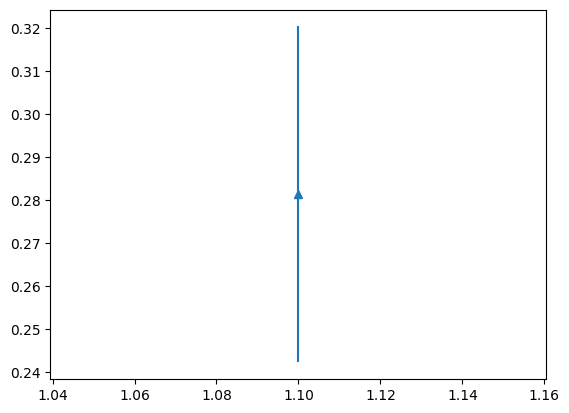

In [25]:
x, y, e = [], [], []

for vel in np.arange(0.1, 0.2, 0.1):
    x.append(float(key[:3]))
    y.append(float(np.mean(dic[key][0])))
    e.append(float(np.std(dic[key][0])))

plt.errorbar(x, y, e, linestyle='None', marker='^')

In [26]:
lol = np.where(np.logical_and(np.isclose(motion[:, 19], 0.1, 0.1))[0]
lol2 = np.where(np.logical_and(np.isclose(motion[:, 19], 0.1, 0.1))[0]

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3672376939.py, line 1)

In [ ]:
x_, y, e = [], [], []

for x in range(len(motion)):
    if x > 1:
        if np.isclose(motion[x-1, 19], 1.2, 0.05) and np.isclose(motion[x, 1], 0.0):
            print(motion[x-1, 19], motion[x, 19], motion[x-1, 1], motion[x, 1])
            x_.append(float(motion[x-1, 19]))
            y.append(float(motion[x, 19]))
            
plt.scatter(x_, y)

In [ ]:
for x in range(len(e)):
    
    print(f"Accelerating from {0.0} to "
np.round(e, 3)

In [ ]:
np.round(y, 3)

In [ ]:
x, y, e = [], [], []

for vel in np.round(np.arange(0.0, 1.2, 0.1), 2):
    start = vel
    key = str(start)+str(vel)
    print(f"{start} -> {vel}. Mean: {np.round(np.mean(dic[key][0]), 3)}. Std: {np.round(np.std(dic[key][0]), 3)}")
    x.append(vel)
    y.append(float(np.mean(dic[key][0])))
    e.append(float(np.std(dic[key][0])))

plt.errorbar(x, y, e, linestyle='None', marker='^')